In [1]:
%matplotlib inline
import glob
import h5py
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import skopi as sk

import time
import numpy as np
from tqdm import tqdm

from IPython.display import clear_output
from sklearn.decomposition import PCA, IncrementalPCA

In [2]:
cryo_exp_dataset_dir='/sdf/scratch/fpoitevi/anass_internship/datasets/cryoem/exp/'
cryo_sim_dataset_dir='/sdf/scratch/fpoitevi/anass_internship/datasets/cryoem/sim/'

cryo_sim_dataset=f'{cryo_sim_dataset_dir}4v6x_randomrot_copy0_defocus1.0_no_noise.h5'
cryo_sim_data = h5py.File(cryo_sim_dataset, 'r')

cryo_exp_dataset=f'{cryo_exp_dataset_dir}refine3D_180x180_sort.h5'
cryo_exp_data = h5py.File(cryo_exp_dataset, 'r')

In [3]:
class batch_PCA:

    """
    batch_PCA: compute PCA of a given image batch.
    """

    def __init__(self, batch):
        """
        """
        self.batch = batch
        self.n_images, self.nx, self.ny = batch.shape
        self.components, self.explained_variance_ratio_ = self._compute_components()

    def _compute_components(self):
        """
        """
        try:
            start_time = time.time()
            pca = PCA()
            pca.fit(self.batch.reshape(self.n_images, self.nx*self.ny))
            fit_time = time.time()
            print(f'PCA> fit in {(fit_time - start_time):.2f} s')
        except:
            print("PCA of batch did not succeed. Try run_PCA()")
        components = pca.transform(self.batch.reshape(self.n_images, self.nx*self.ny))
        explained_variance_ratio_ = pca.explained_variance_ratio_
        transform_time = time.time()
        print(f'PCA> components transformed in {(transform_time - fit_time):.2f} s')
        return components, explained_variance_ratio_

    def _compute_eigenimages(self):
        """
        """
        try:
            start_time = time.time()
            eigenimages = np.dot(self.components.T,
                                 self.batch.reshape(self.n_images, self.nx*self.ny))
            dot_time = time.time()
            print(f'PCA> eigenimages computed in {(dot_time - start_time):.2f} s')
        except:
            print("Error. Check that components were computed first.")
        return eigenimages.reshape(self.n_images, self.nx, self.ny)

In [4]:
cryo_sim_data['data']

<HDF5 dataset "data": shape (48, 648, 648), type "<f4">

In [5]:
pca = batch_PCA(cryo_sim_data['data'][:])

PCA> fit in 2.02 s
PCA> components transformed in 0.07 s


In [6]:
cryo_sim_dataset_2=f'{cryo_sim_dataset_dir}4v6x_randomrot_copy1_defocus1.0_no_noise.h5'
cryo_sim_data_2 = h5py.File(cryo_sim_dataset, 'r')

In [6]:
components, explained_variance_ratio = pca._compute_components()

PCA> fit in 2.05 s
PCA> components transformed in 0.08 s


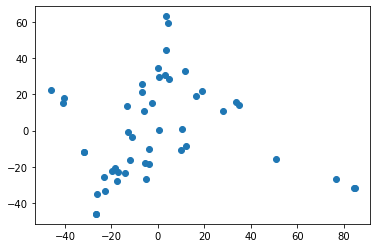

In [9]:
plt.scatter(components[:,0], components[:,1])

In [10]:
eigenimage = pca._compute_eigenimages()

PCA> eigenimages computed in 0.06 s


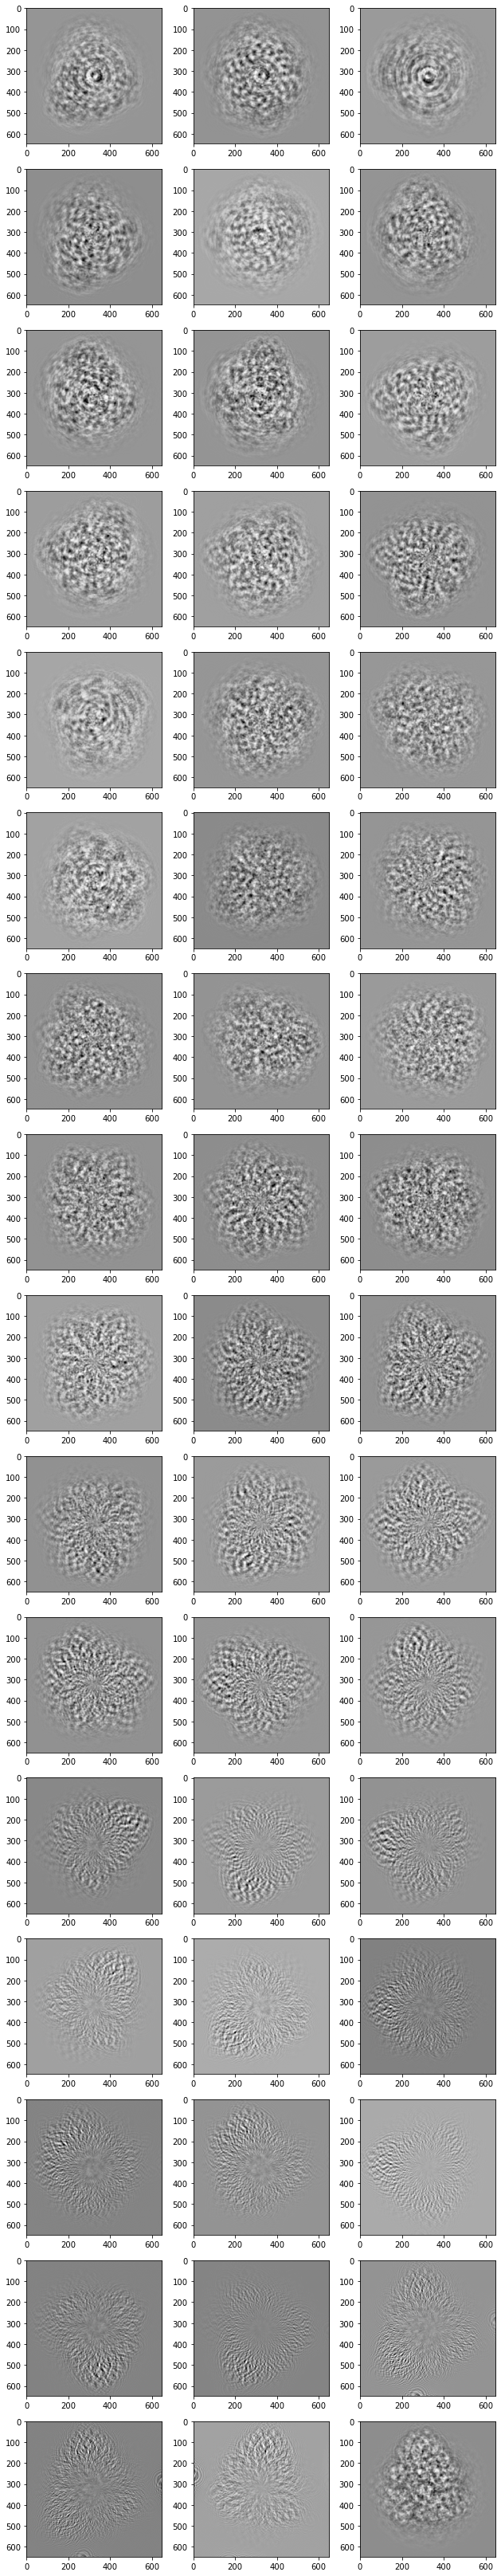

In [11]:
nrows=16
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 9*(nrows//ncols)))
for i in range(nrows):
    for j in range(ncols):
        image = eigenimage[i*ncols+j]
        axs[i,j].imshow(image, interpolation='none', cmap='Greys_r')
plt.tight_layout()

In [12]:
eigenimage.shape

(48, 648, 648)

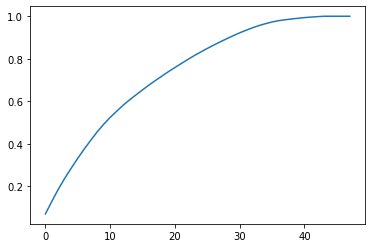

In [12]:
plt.plot(np.cumsum(explained_variance_ratio))